### Prediction for other cell lines

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip()  # 去除首位空格
    path = path.rstrip("\\")  # 去除尾部 \ 符号
    isExists = os.path.exists(path)  # 判断路径是否存在
    # 判断结果
    if not isExists:
        os.makedirs(path)  # 如果不存在则创建目录
        print(path + ' 创建成功')
    else:
        print(path + ' 目录已存在')  # 如果目录存在则不创建，并提示目录已存在

        
def walk(path):
    import os
    input_path_list = []
    if not os.path.exists(path):
        return -1
    for root, dirs, names in os.walk(path):
        for filename in names:
            input_path = os.path.join(root, filename)
            input_path_list.append(input_path)
    return input_path_list

In [3]:
##
def get_plot_data(cell_line, data_dir, comp_models, test_label_list):
    test_data_list = []
    for model_label in comp_models:
        if model_label in ['K562', 'Jurkat']:
            one_data_dir = data_dir%('Self-%s'%(model_label))
        else:
            one_data_dir = data_dir%(model_label)
        for test_label in test_label_list:
            test_data_path = one_data_dir + '/eval_%s_by_%s_based_on_%s_labels.csv'%(test_label, model_label, cell_line)
            test_data = pd.read_csv(test_data_path)
            test_data['model'] = model_label
            test_data['data label'] = test_label
            test_data_list.append(test_data)
    ## concat
    test_data = pd.concat(test_data_list, axis=0)
    test_data.reset_index(drop=True, inplace=True)
    return test_data


## plot: the effect of off-target insertion XA+YA+Z0 nucleotide type on editing efficiency
def plot_comparison_dsv_models(data, y, order, savefig_path):
    import matplotlib.pyplot as plt
    import seaborn as sns
    # 设置默认绘图风格
    plt.style.use("seaborn-white")  
    fig, ax = plt.subplots(1,1, figsize=(8.0, 4.0))

    palette = {'Aidit_Cas9-DSB K562': 'purple', 
               'ForeCasT': 'y', 
               'Lindel': 'g', 
               'Aidit_Cas9-DSB Jurkat': 'royalblue'}
    import copy
    cdata = copy.deepcopy(data)
    rename_model_label_dict = {'K562': 'Aidit_Cas9-DSB K562', 
                               'Jurkat': 'Aidit_Cas9-DSB Jurkat', 
                               'ForeCasT': 'ForeCasT', 
                               'Lindel': 'Lindel'}
    cdata['model_label'] = cdata['model_label'].apply(lambda x: rename_model_label_dict[x])
    ax = sns.boxplot(x='data_label', y=y, hue='model_label', data=cdata, palette=palette, width=0.8, 
                     fliersize=0., linewidth=0.5, order=order, notch=True)
    ## 坐标轴不可见
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ## xlabel, ylabel
    if y == 'pearson':
        ylabel = 'Pearson coefficient'
        plt.ylim(-0.05, 1.09)
    elif y == 'spearman':
        ylabel = 'Spearman coefficient'
        plt.ylim(0.1, 0.95)
    elif y == 'symKL':
        ylabel = 'Symmetrized KL divergence'
        plt.ylim(-0.3, 6)
    else:
        ylabel = 'MSE'
        plt.ylim(-0.0005, 0.004)

    plt.ylabel(ylabel, fontsize=12, weight='bold')
    plt.xlabel('Independent test dataset', fontsize=12, weight='bold')
    ## xticks
    xticks = []
    for c in order:
        if c[:2] == 'H1':
            xticks.append('H1')
        else:
            xticks.append(c)
    plt.xticks(range(len(xticks)), xticks, fontsize=10, weight='bold',
              rotation=45)
    ## title 
    title = 'Comparison of performance of DSB repair models'
    plt.title(title, fontsize=12, weight='bold')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()
#############################################################

./pdf/DSB/FigExtra-model comparison 目录已存在


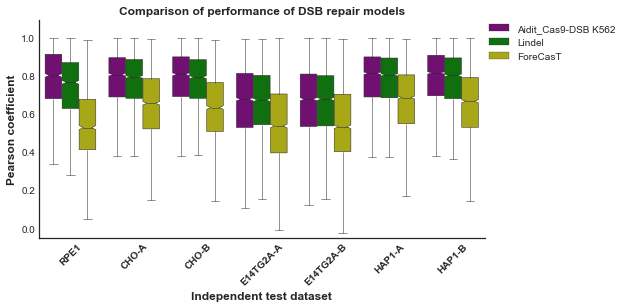

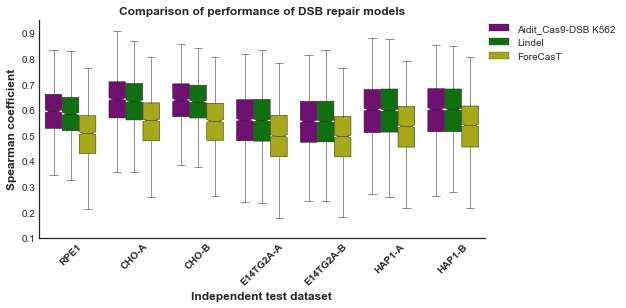

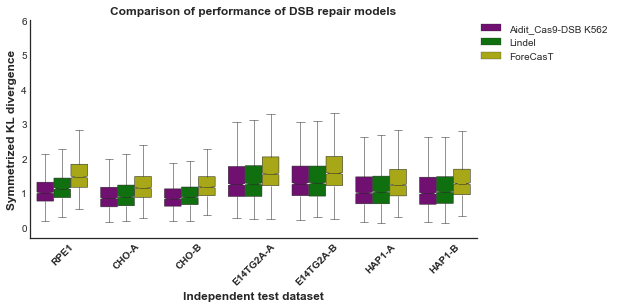

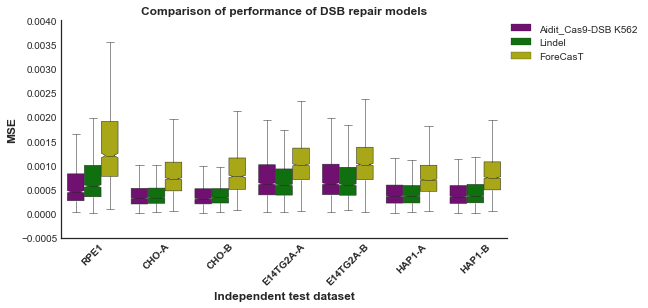

In [4]:
main_path = "../../data"
os.chdir(main_path)

figsuplix = 'pdf'
savefig_dir = "./%s/DSB/FigExtra-model comparison"%figsuplix
mkdir(savefig_dir)
cell_line = 'K562'
test_label_list = ['RPE1', 'CHO-A', 'CHO-B', 'E14TG2A-A', 'E14TG2A-B', 'HAP1-A', 'HAP1-B', 
                  'ForeCasT-val-A', 'ForeCasT-val-B'
                  ]
order = ['RPE1', 'CHO-A', 'CHO-B', 'E14TG2A-A', 'E14TG2A-B', 'HAP1-A', 'HAP1-B']
comp_models = [cell_line, 'Lindel', 'ForeCasT']
data_dir = './DSB/Prediction/%s/Other'
plot_data = get_plot_data(cell_line, data_dir, comp_models, test_label_list)
plot_data.head()
## plot
plot_data.rename(columns={'model': 'model_label', 'data label': 'data_label'}, inplace=True)

for y in ['pearson', 'spearman', 'symKL', 'MSE']:
    savefig_path = savefig_dir + '/DSB model comparison on different cells-%s-%s.%s'%(cell_line, y, figsuplix)
    plot_comparison_dsv_models(plot_data, y, order, savefig_path)